In [1]:
import ingestor, modeller, fitter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-notebook')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
from cycler import cycler

new_color = cycler(color=["k"])
plt.rcParams['axes.prop_cycle'] = plt.rcParams['axes.prop_cycle'].concat(new_color)

In [4]:
from importlib import reload

reload(fitter)
reload(modeller)
reload(ingestor)

<module 'ingestor' from '/media/dwu402/Data/wrap-mad/ingestor.py'>

In [5]:
context = ingestor.Context("runs/minimal3.3.run")

In [6]:
model = modeller.Model(context)

In [7]:
solver = fitter.Fitter()
solver.construct_objectives(context, model)

In [8]:
solver.construct_problems()

In [9]:
for rhoi in np.logspace(-7, 4.5, num=51):
    solver.solve(rhoi)
    solver.problems[0].initial_guess = solver.solutions[str(rhoi)][-1].x

In [10]:
solver.solutions

{'1e-07': [      fun: 0.009769724762800525
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([ 7.83767880e-14, -3.29762767e-13,  4.14931009e-13, -6.71932110e-13,
         -1.38075815e-11,  5.21768544e-11,  2.26872019e-11,  1.41893791e-11,
         -2.66128147e-11,  1.53658600e-13,  2.55399452e-11])
    message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
       nfev: 3
        nit: 2
     status: 0
    success: True
          x: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])],
 '1.6982436524617461e-07': [      fun: 0.009769724762800525
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([ 1.28492624e-12,  2.14334655e-13,  5.49323424e-13, -6.43176529e-13,
         -1.35747308e-11,  5.10750656e-11,  1.75809963e-11,  2.80658575e-11,
         -3.03025061e-11,  3.52709468e-12,  2.61407238e-11])
    message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
       nfev: 1
        nit: 0
     status: 0
    success: True
  

Text(0.5, 0, '$\\rho$, Model Weighting Parameter')

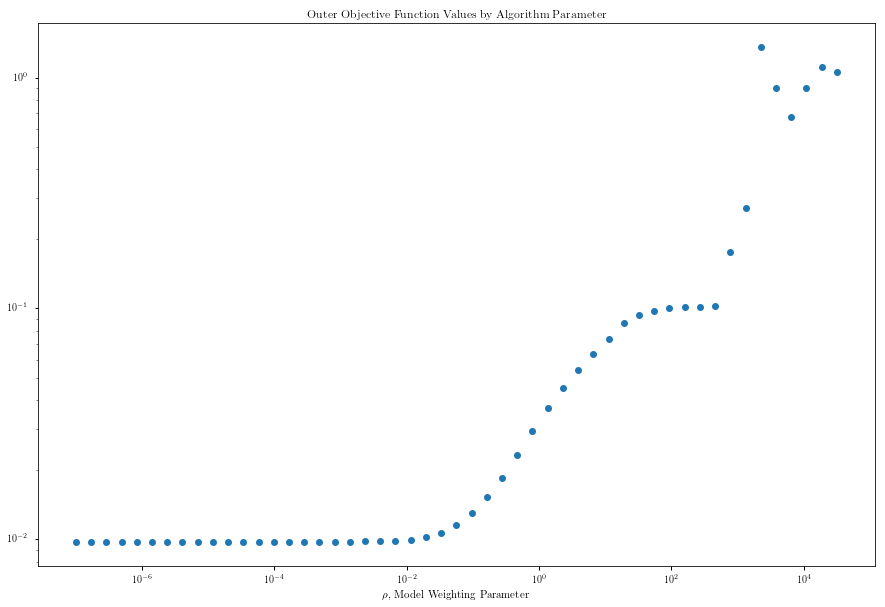

In [11]:
outer_objective_values = np.array([[float(rho), val[0].fun] for rho, val in solver.solutions.items()])
plt.loglog(*outer_objective_values.T, 'o')
plt.title("Outer Objective Function Values by Algorithm Parameter")
plt.xlabel(r"$\rho$, Model Weighting Parameter")

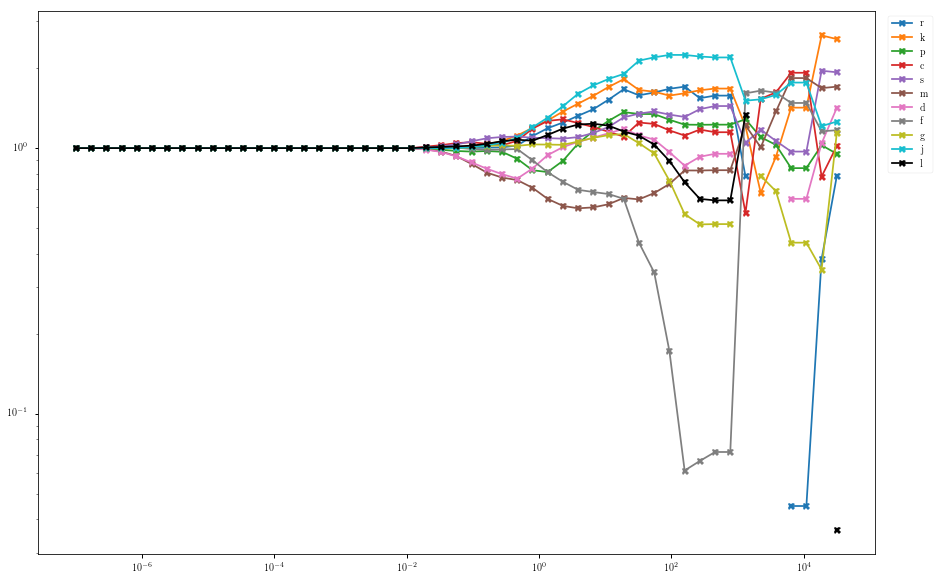

In [12]:
rhos = [float(rho) for rho in solver.solutions.keys()]
vals = [val[0].x for val in solver.solutions.values()]
plt.plot(rhos, vals, 'X-')
plt.legend("rkpcsmdfgjl", loc="best", bbox_to_anchor=(1.01, 1))
plt.xscale("log")
plt.yscale("log", nonposy="mask")

In [13]:
# generate a crude correlation plot

import pandas as pd

results = pd.DataFrame({r"$\rho$": np.log(rhos)})
for idx, name in enumerate("rkpcsmdfgjl"):
    results[name] = [v[idx] for v in vals]
    

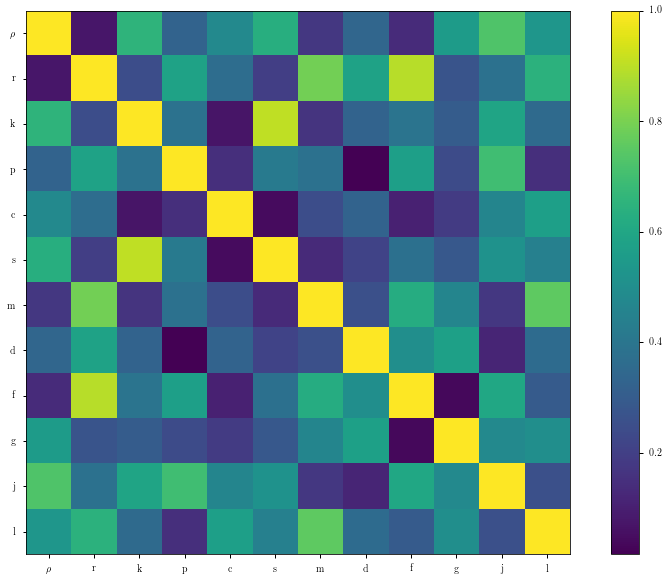

In [14]:
plt.imshow(np.abs(results.corr()))
plt.colorbar()
plt.xticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.yticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.grid(False)

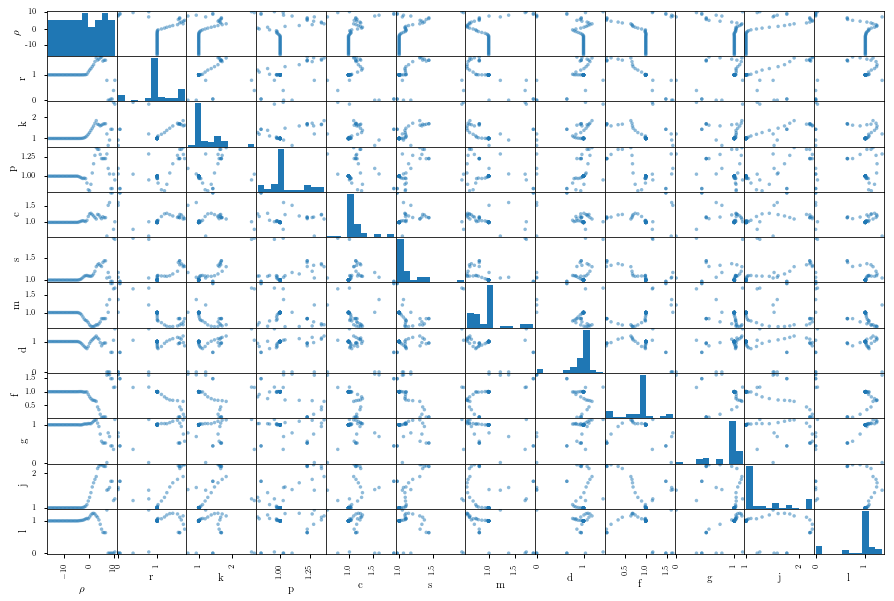

In [15]:
ax = pd.plotting.scatter_matrix(results)
for a in ax.flatten():
    a.grid(False)

Text(0, 0.5, 'Number')

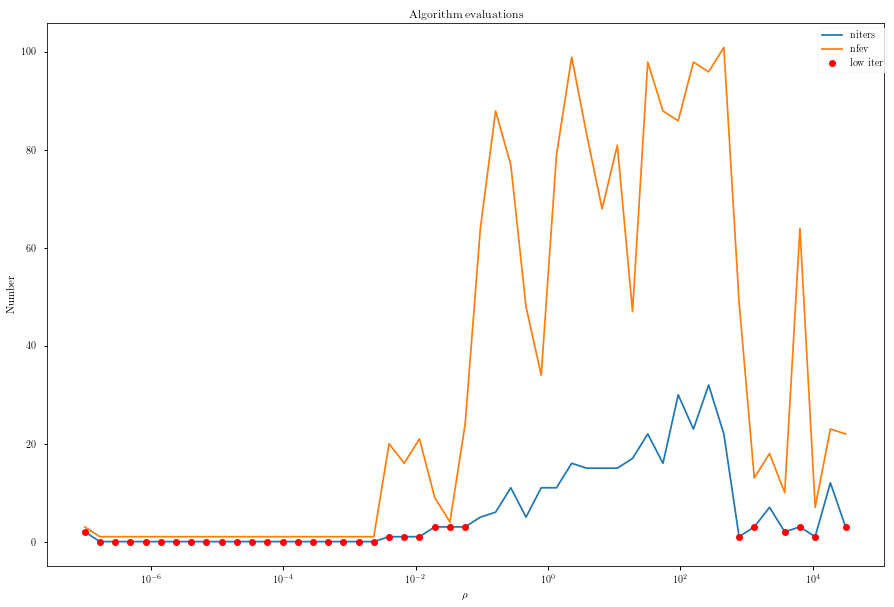

In [16]:
iters_list = np.array([[float(key), value[0].nit] for key, value in solver.solutions.items()])
fevs_list = np.array([[float(key), value[0].nfev] for key, value in solver.solutions.items()])
plt.semilogx(*iters_list.T, *fevs_list.T)

low_iters = np.array([[k,v] for k,v in iters_list if v < 5])
plt.plot(*low_iters.T, 'ro')

plt.legend(["niters", "nfev", "low iter"], 
           loc="best", bbox_to_anchor=(1.01, 1))
plt.title("Algorithm evaluations")
plt.xlabel(r"$\rho$")
plt.ylabel("Number")

In [17]:
def tokey(rho, ps):
    return f"{'y'.join(map(str,ps))}r{rho}"
getx = fitter.ca.Function("getx", [model.ts, *model.cs], model.xs)
    

[1.6725086  1.5765243  1.27887253 1.16591702 1.33716126 0.732705
 0.96569362 0.17193503 0.7541414  2.24350398 0.89465985]
[[ 0.0045466  0.714481  -0.233282 ]]


Text(0.5, 0, 'time, t')

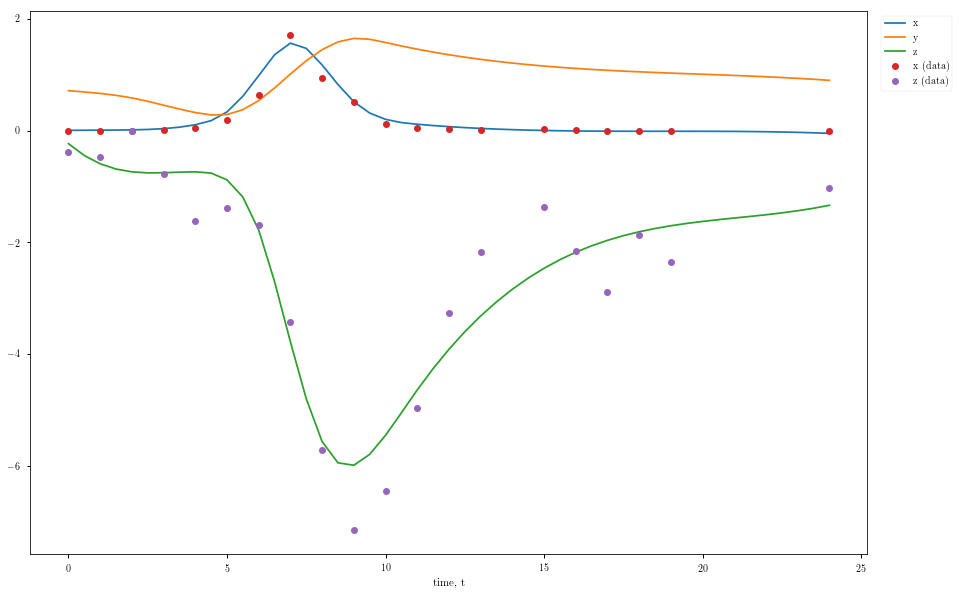

In [33]:
target_rho = 93.32543007969925
c_end = solver.problems[0].cache.results[tokey(target_rho, solver.solutions[str(target_rho)][0].x)].x
print(solver.solutions[str(target_rho)][0].x)
xs_end = np.array([np.array(i) for i in getx(model.observation_times, 
                                         *fitter.argsplit(c_end, 
                                                          3)
                                        )])
print(xs_end[:,0].T)
plt.plot(model.observation_times, np.hstack([xs_end[0], xs_end[1], xs_end[2]]),
         context.datasets[0]['t'], context.datasets[0]['x'], 'o',
         context.datasets[0]['t'], context.datasets[0]['z'], 'o')
plt.legend(list("xyz") + ["x (data)", "z (data)"], loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("time, t")

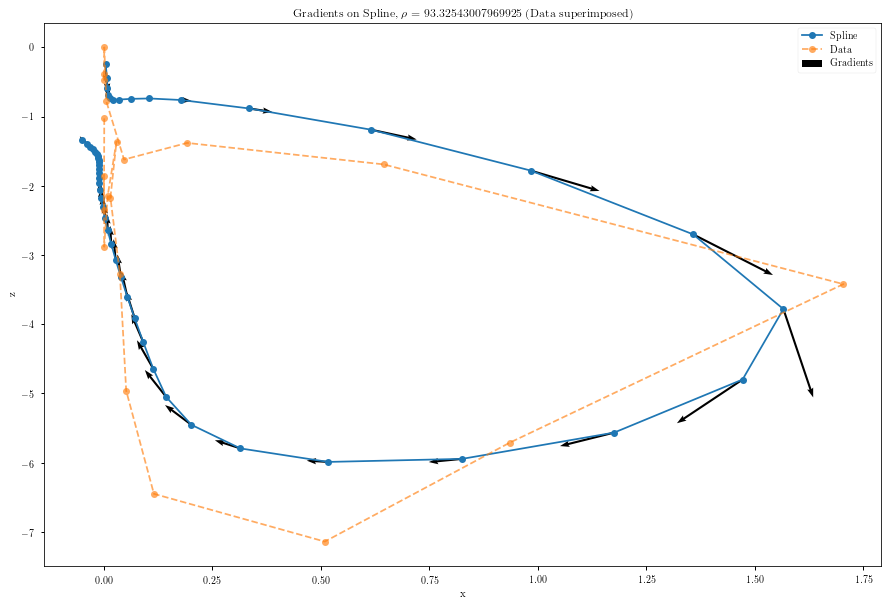

In [29]:
spline_dfield = np.array([context.model(t, xs_end[:,i], solver.solutions[str(target_rho)][0].x) 
                 for i,t in enumerate(model.observation_times)])

spline_dfield = spline_dfield.reshape(spline_dfield.shape[:2])

plt.plot(xs_end[0], xs_end[2], 'o-')
plt.plot(context.datasets[0]['x'], context.datasets[0]['z'], 'o--', alpha=0.65)
plt.quiver(xs_end[0], xs_end[2], spline_dfield[:,0], spline_dfield[:,2], 
           scale=v220, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho} (Data superimposed)")
plt.xlabel("x")
plt.ylabel("z")
plt.legend(["Spline", "Data", "Gradients"])

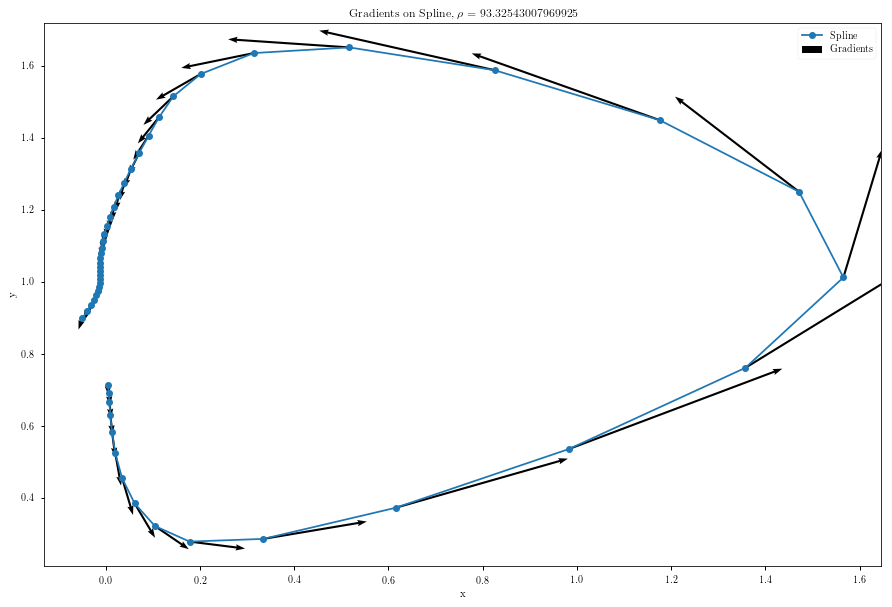

In [30]:
plt.plot(xs_end[0], xs_end[1], 'o-')
plt.quiver(xs_end[0], xs_end[1], spline_dfield[:,0], spline_dfield[:,1], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Spline", "Gradients"])

In [21]:
inner_objective_values = np.array([[r, solver.problems[0].cache.results[tokey(r, v)].fun] for r,v in zip(rhos, vals)])
dfield = np.hstack([np.array(rhos).reshape(-1,1), 
                    ((inner_objective_values - outer_objective_values)[:,1] / rhos).reshape(-1,1)])


Text(0, 0.5, 'Diff Field')

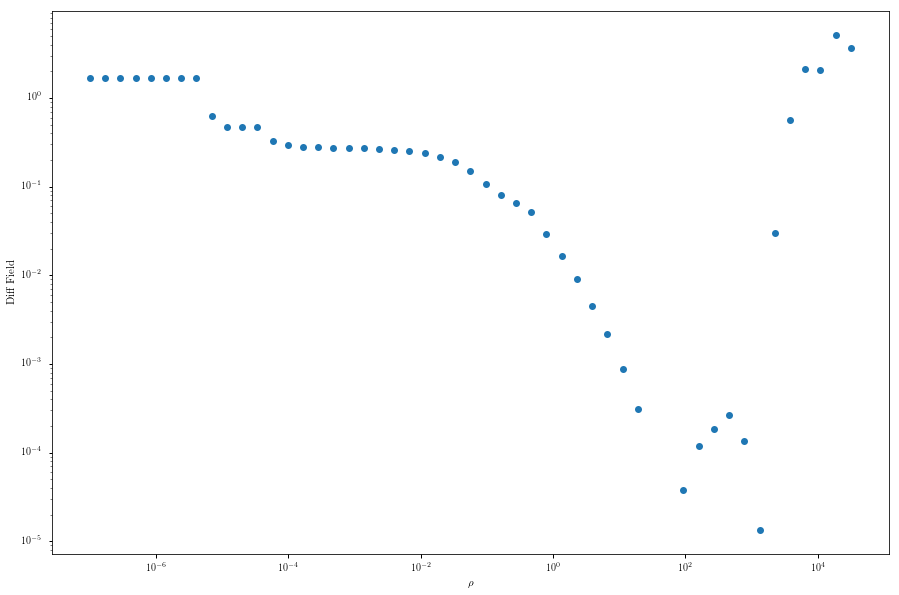

In [22]:
plt.loglog(*dfield.T, 'o')
plt.xlabel(r"$\rho$")
plt.ylabel("Diff Field")

Text(0, 0.5, 'Diff Field')

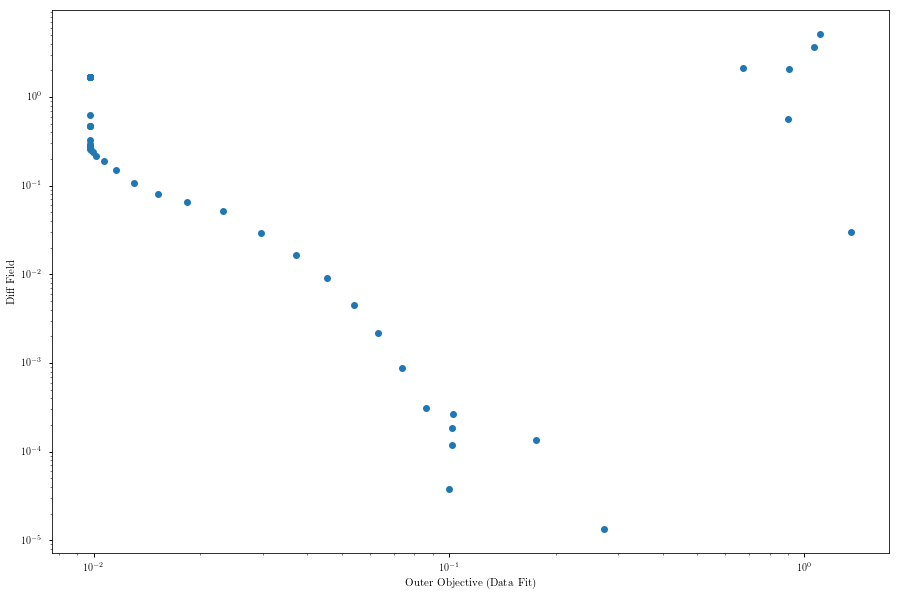

In [23]:
plt.loglog(outer_objective_values[:,1], dfield[:,1], 'o')
plt.xlabel("Outer Objective (Data Fit)")
plt.ylabel("Diff Field")

/home/dwu402/.virtualenvs/scider/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Text(0, 0.5, '$\\kappa$')

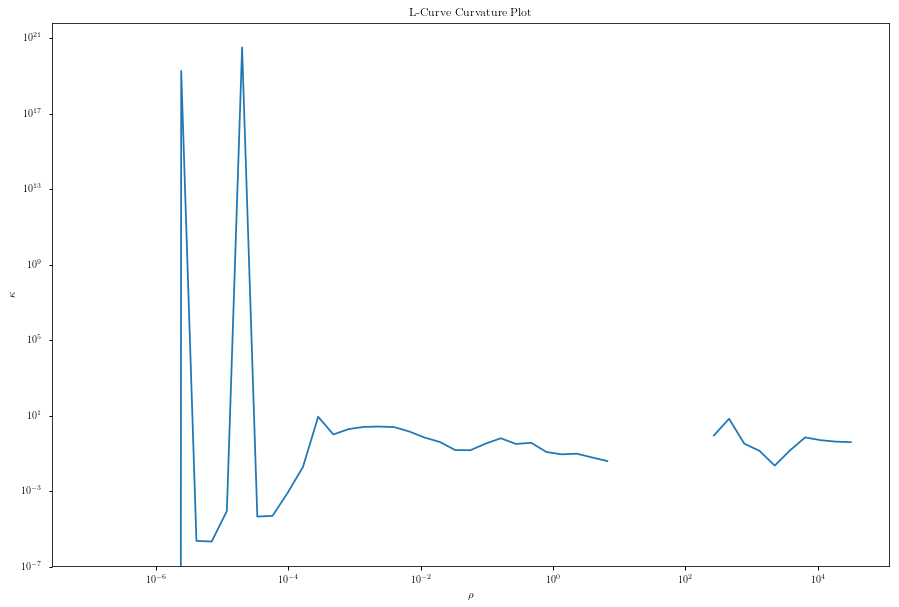

In [24]:
curv_dx = np.gradient(np.log(outer_objective_values[:,1]))
curv_dy = np.gradient(np.log(dfield[:,1]))
curv_dx2 = np.gradient(curv_dx)
curv_dy2 = np.gradient(curv_dy)

kappa = np.abs(curv_dx*curv_dy2 - curv_dy*curv_dx2)/(curv_dx**2 + curv_dy**2)**(3/2)

plt.loglog(rhos, kappa)
plt.title("L-Curve Curvature Plot")
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\kappa$")

In [25]:
rhos

[1e-07,
 1.6982436524617461e-07,
 2.8840315031266057e-07,
 4.897788193684466e-07,
 8.317637711026709e-07,
 1.4125375446227554e-06,
 2.3988329190194897e-06,
 4.073802778041131e-06,
 6.9183097091893625e-06,
 1.1748975549395302e-05,
 1.995262314968883e-05,
 3.3884415613920276e-05,
 5.7543993733715664e-05,
 9.772372209558111e-05,
 0.00016595869074375615,
 0.0002818382931264455,
 0.00047863009232263854,
 0.0008128305161640995,
 0.0013803842646028866,
 0.0023442288153199225,
 0.003981071705534978,
 0.006760829753919818,
 0.01148153621496884,
 0.019498445997580455,
 0.03311311214825914,
 0.05623413251903491,
 0.09549925860214369,
 0.16218100973589297,
 0.2754228703338169,
 0.4677351412871981,
 0.7943282347242822,
 1.3489628825916533,
 2.290867652767775,
 3.890451449942813,
 6.606934480075965,
 11.220184543019652,
 19.054607179632523,
 32.35936569296281,
 54.954087385762485,
 93.32543007969925,
 158.48931924611173,
 269.1534803926914,
 457.0881896148752,
 776.2471166286928,
 1318.25673855641,


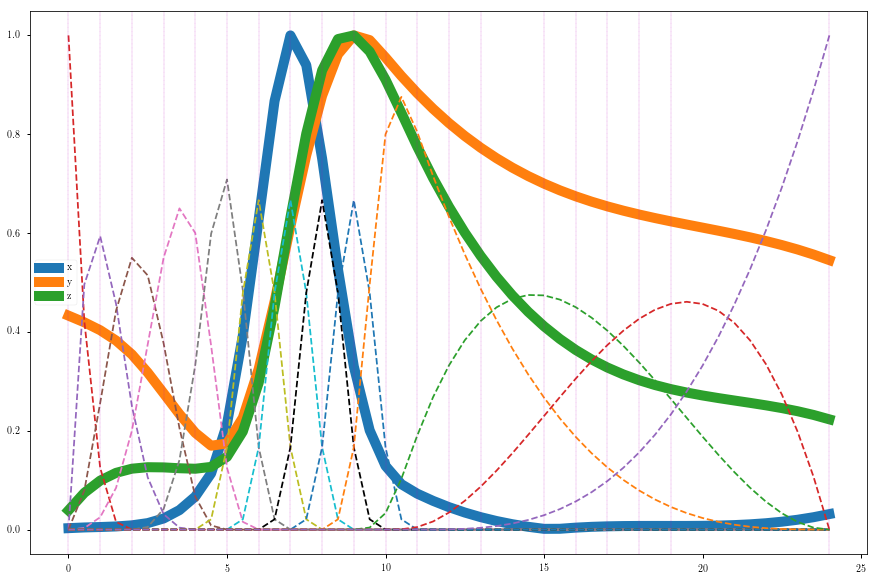

In [34]:
bfn = modeller.ca.Function('basis_fns', [model.ts], [model.basis])
plt.plot(model.observation_times, np.abs(np.hstack([xs_end[0]/max(abs(xs_end[0])), 
                                             xs_end[1]/max(abs(xs_end[1])), 
                                             xs_end[2]/max(abs(xs_end[2]))])),
         linewidth=10)
plt.plot(model.observation_times, bfn(model.observation_times), '--')
plt.legend('xyz')
[plt.axvline(x=i, color='m', linewidth=0.25, linestyle='--') for i in context.datasets[0]['t']]
print("")

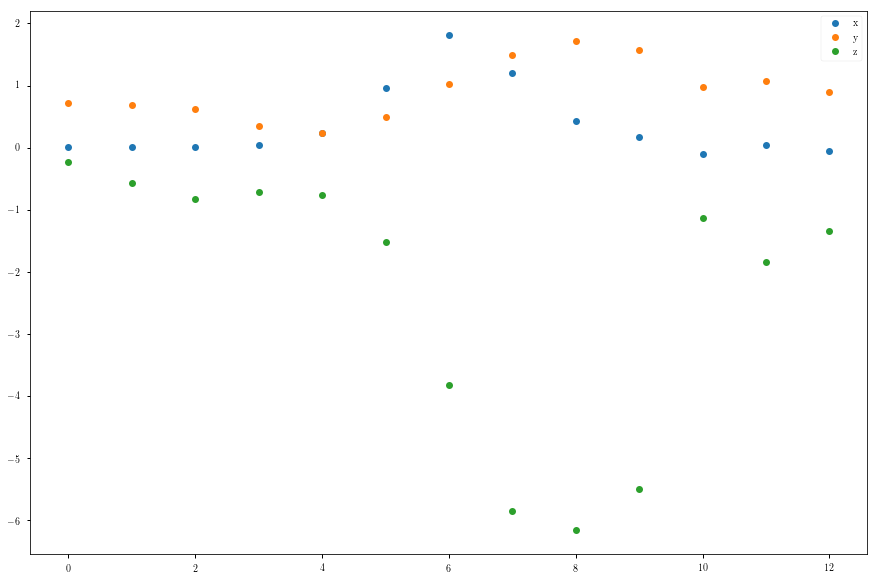

In [35]:
plt.plot(range(model.K), np.array(fitter.argsplit(c_end, 3)).T, 'o')
plt.legend('xyz')
